In [1]:
import torch
from torchvision import models

import matplotlib.pyplot as plt
from time import time

%matplotlib inline

device = "cuda" if torch.cuda.is_available() else "cpu"
print("using device %s" % device)

using device cuda


In [4]:
model = models.resnet50(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
model.eval()

import numpy as np
import requests
from PIL import Image
url = 'https://lionsvalley.co.za/wp-content/uploads/2015/11/african-elephant-square.jpg'
image = Image.open(requests.get(url, stream=True).raw).convert("RGB")
image = np.array(image)
image = torch.Tensor(image)

In [7]:
image = image / 255

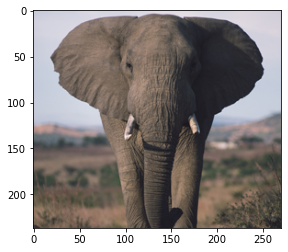

In [8]:
plt.imshow(image)

In [10]:
image_net_classes = 'https://gist.githubusercontent.com/yrevar/942d3a0ac09ec9e5eb3a/raw/238f720ff059c1f82f368259d1ca4ffa5dd8f9f5/imagenet1000_clsidx_to_labels.txt'
image_net_classes = requests.get(image_net_classes).text
image_net_ids = eval(image_net_classes)
image_net_classes = {i:j for j,i in image_net_ids.items()}


In [14]:
import torch.nn.functional as F

In [66]:
model = model.to(device)
image = image.to(device)
def predict_on_image(model, image, show=True):
    model.eval()
    if show:
        plt.imshow(image.cpu())
    x = image.permute(2, 0, 1).unsqueeze(0)
    pred = model(x)
    pred = F.softmax(pred, dim=1)[0]
    prob, clss_id = torch.max(pred, 0)
    clss = image_net_ids[clss_id.item()]
    if show:
        print('class: %s, prob: %.2f' % (clss, prob.cpu().item()))
    return clss_id.cpu().item(), prob.item()

class: African elephant, Loxodonta africana, prob: 0.49


(386, 0.4939233362674713)

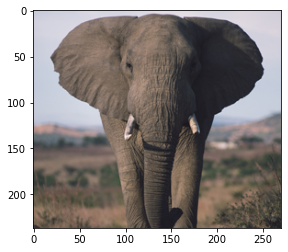

In [67]:
predict_on_image(model, image)

In [74]:
lossfn = torch.nn.CrossEntropyLoss()
def attack(model, image, target, eps=1e-6):
    model.eval()
    image = image.permute(2, 0, 1).unsqueeze(0)
    image.requires_grad = True
    pred = model(image)
    loss = lossfn(pred, target)
    image.grad = torch.zeros_like(image)
    loss.backward()
    image = image - eps * image.grad.sign()
    image = image.squeeze(0).permute(1, 2, 0)
    return image.detach(), loss.item()



current cls: 386, prob: 0.49, loss: 14.77
current cls: 386, prob: 0.49, loss: 14.71
current cls: 386, prob: 0.50, loss: 14.65
current cls: 386, prob: 0.50, loss: 14.59
current cls: 386, prob: 0.50, loss: 14.53
current cls: 386, prob: 0.50, loss: 14.47
current cls: 386, prob: 0.50, loss: 14.41
current cls: 386, prob: 0.50, loss: 14.35
current cls: 386, prob: 0.50, loss: 14.30
current cls: 386, prob: 0.50, loss: 14.25
current cls: 386, prob: 0.50, loss: 14.19
current cls: 386, prob: 0.50, loss: 14.14
current cls: 386, prob: 0.50, loss: 14.09
current cls: 386, prob: 0.50, loss: 14.05
current cls: 386, prob: 0.50, loss: 14.00
current cls: 386, prob: 0.50, loss: 13.95
current cls: 386, prob: 0.50, loss: 13.90
current cls: 386, prob: 0.50, loss: 13.86
current cls: 386, prob: 0.50, loss: 13.81
current cls: 386, prob: 0.50, loss: 13.77
current cls: 386, prob: 0.50, loss: 13.72
current cls: 386, prob: 0.50, loss: 13.68
current cls: 386, prob: 0.50, loss: 13.64
current cls: 386, prob: 0.50, loss

(7, 0.9000707268714905)

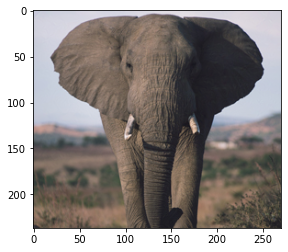

In [75]:

abc = image.clone().detach()
t = 9
target = torch.tensor([t]).to(device)

while True:
    abc, loss = attack(model, abc, target, eps=1e-4)
    cls, prob = predict_on_image(model, abc, show=False)
    if cls == t and prob > 0.9:
        break
    print("current cls: %d, prob: %.2f, loss: %.2f" % (cls, prob, loss))

predict_on_image(model, abc)


class: African elephant, Loxodonta africana, prob: 0.49


(386, 0.4939233362674713)

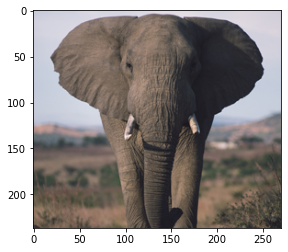

In [76]:
predict_on_image(model, image)

class: cock, prob: 0.90


(7, 0.9000707268714905)

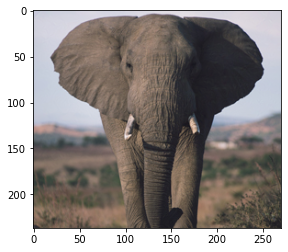

In [77]:
predict_on_image(model, abc)